In [15]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

print(f"loaded chain with {len(chain)} blocks, last block is from {chain.blocks[-1].time}")

loaded chain with 906158 blocks, last block is from 2025-07-19 00:39:40


# Percentage of used scripts in time

Observe how the used scripts changed over time. All scripts using witnesses are in the `SegWit` category.

CPU times: user 16min 51s, sys: 13.1 s, total: 17min 5s
Wall time: 5.35 s


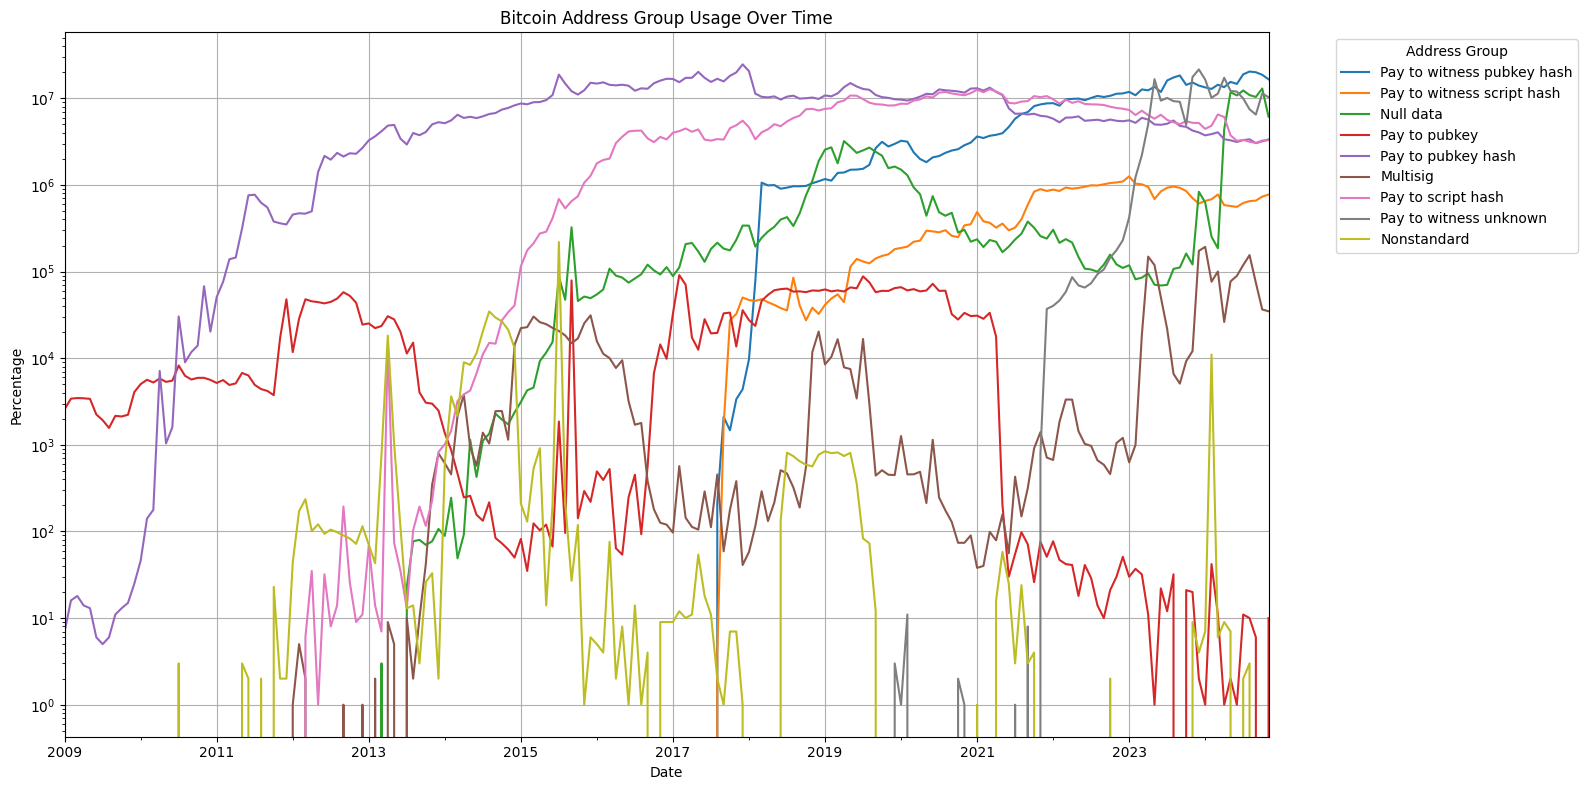

Pay to witness pubkey hash    5.998778e+08
Pay to witness script hash    4.102494e+07
Null data                     1.347893e+08
Pay to pubkey                 3.579348e+06
Pay to pubkey hash            1.366634e+09
Multisig                      2.058709e+06
Pay to script hash            7.422646e+08
Pay to witness unknown        2.340083e+08
Nonstandard                   4.445270e+05
dtype: float64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%time data = chain.get_count_of_address_types_for_each_day(0, len(chain))

df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna(0).T  # Transpose to make days the rows
df.index = pd.to_datetime(df.index.map(lambda x: datetime.utcfromtimestamp(x * 86400)))

group_mapping = {
    #blocksci.address_type.witness_pubkeyhash: "segwit",
    #blocksci.address_type.witness_unknown: "segwit",
    #blocksci.address_type.nonstandard: "", 
    #blocksci.address_type.witness_scripthash: "segwit",
}

# segwit_total = df[group_mapping.keys()].sum(axis=1)  # Sum up all segwit categories
# df["SegWit"] = segwit_total 

df = df.drop(columns=group_mapping.keys())

df = df.resample('M').sum()

# df['total'] = df.sum(axis=1)

# percentages = df.div(df['total'], axis=0) * 100
# percentages = percentages.drop(columns=['total'])


plt.figure(figsize=(16, 8))
df.plot(kind='line', ax=plt.gca())

plt.legend(title='Address Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Bitcoin Address Group Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.yscale('log')
plt.grid()

plt.tight_layout()

# plt.savefig('/mnt/blocksci/address_group_usage_percent.png')
plt.show()

print(df.sum())

# CoinJoins


In [2]:
# last_february_block = get_block_height_for_date('2025-03-01')

# %time ww2_coinjoins = chain.filter_coinjoin_txes(get_block_height_for_date('2024-09-01'),get_block_height_for_date('2024-10-01'), "wasabi2")
# %time ww2_coinjoins = chain.filter_coinjoin_txes(get_block_height_for_date('2024-09-01'),get_block_height_for_date('2024-10-01'), "wasabi1")
# %time ww2_coinjoins = chain.filter_coinjoin_txes(get_block_height_for_date('2024-09-01'),get_block_height_for_date('2024-10-01'), "whirlpool")
%time ww2_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "wasabi2", min_input_count=10)
%time ww1_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "wasabi1")
%time sw_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "whirlpool")

# print(len(ww2_coinjoins), len(ww1_coinjoins), len(sw_coinjoins))
# all_coinjoins = set(ww2_coinjoins) | set(ww1_coinjoins) | set(sw_coinjoins)

CPU times: user 11min 35s, sys: 1min 10s, total: 12min 46s
Wall time: 10min 11s
CPU times: user 2min 51s, sys: 1.65 s, total: 2min 53s
Wall time: 2.59 s
CPU times: user 1min 46s, sys: 638 ms, total: 1min 46s
Wall time: 2.02 s


In [3]:
%time ww2_coinjoins_min = chain.filter_coinjoin_txes(0, len(chain), "wasabi2")
%time ashigaru_coinjoins = chain.filter_coinjoin_txes(0, len(chain), "ashigaru")
print(len(ww2_coinjoins_min), len(ww1_coinjoins), len(sw_coinjoins), len(ashigaru_coinjoins))


CPU times: user 2min 1s, sys: 318 ms, total: 2min 1s
Wall time: 1.46 s
CPU times: user 2min, sys: 240 ms, total: 2min
Wall time: 737 ms
65824 34929 541107 128


## Number of coinjoins in the wild

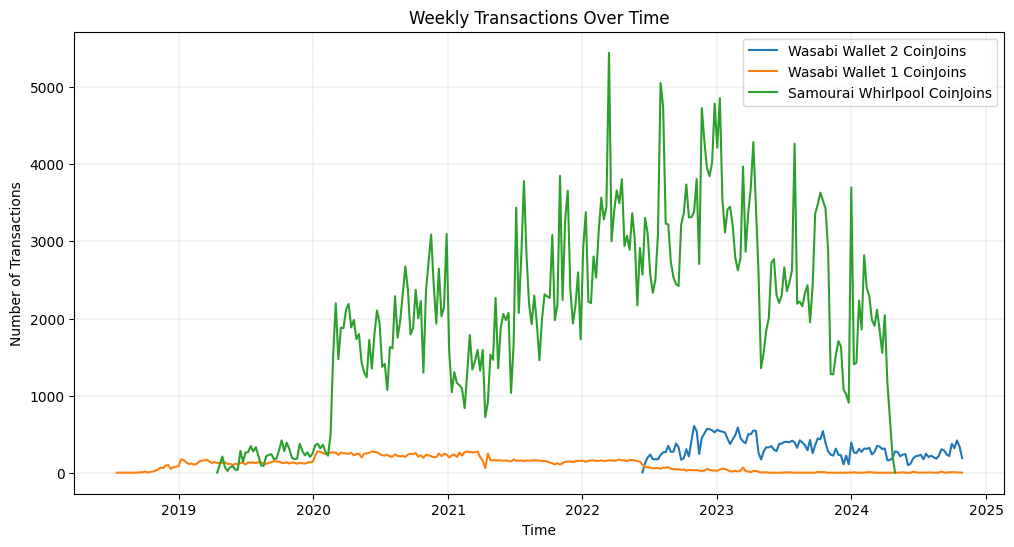

In [4]:
def process_transactions(transactions, label):
    transactions = list(map(lambda tx: {"block_time": tx.block_time}, transactions))
    df = pd.DataFrame(transactions)
    df['block_time'] = pd.to_datetime(df['block_time'])
    df['week'] = df['block_time'].dt.to_period('W').dt.to_timestamp()  # Get the timestamp for the start of the week
    weekly_counts = df.groupby('week').size()
    return weekly_counts, label

weekly_counts_ww2, label_1 = process_transactions(ww2_coinjoins, "Wasabi Wallet 2 CoinJoins")
weekly_counts_ww1, label_2 = process_transactions(ww1_coinjoins, "Wasabi Wallet 1 CoinJoins")
weekly_counts_sw, label_3 = process_transactions(sw_coinjoins, "Samourai Whirlpool CoinJoins")

plt.figure(figsize=(12, 6))

plt.plot(weekly_counts_ww2.index, weekly_counts_ww2.values, label=label_1)
plt.plot(weekly_counts_ww1.index, weekly_counts_ww1.values, label=label_2)
plt.plot(weekly_counts_sw.index, weekly_counts_sw.values, label=label_3)

plt.title("Weekly Transactions Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Transactions")
plt.legend()

plt.grid(True, linestyle='--', linewidth=0.3)
plt.savefig("/mnt/blocksci/weekly_cjs_over_time.png")

plt.show()


## Liquidity

In [12]:
tx: blocksci.Tx
i: blocksci.Input
from collections import defaultdict
from datetime import datetime, timedelta

def process_input_liquidity(cjs, label):
    input_liquitidy_per_date = {}
    s = set(cjs)
    
    for tx in cjs:
        tx_date = tx.block_time.date()
        if tx_date not in input_liquitidy_per_date:
            input_liquitidy_per_date[tx_date] = 0
    
        for i in tx.inputs:
            if i.spent_tx in s:
                continue
    
            input_liquitidy_per_date[tx_date] += i.value

    sorted_liquidity = {k: v / 100000000 for k, v in sorted(input_liquitidy_per_date.items(), key=lambda t: t[0]) if k is not None}
    

    return sorted_liquidity, label

liq1, lab1 = process_input_liquidity(ww2_coinjoins, "Wasabi2 Input Liquidity")
liq2, lab2 = process_input_liquidity(ww1_coinjoins, "Wasabi1 Input Liquidity")
liq3, lab3 = process_input_liquidity(sw_coinjoins, "Whirlpool Input Liquidity")
liq4, lab4 = process_input_liquidity(ashigaru_coinjoins, "Ashigaru Input Liquidity")

{<class 'datetime.date'>}


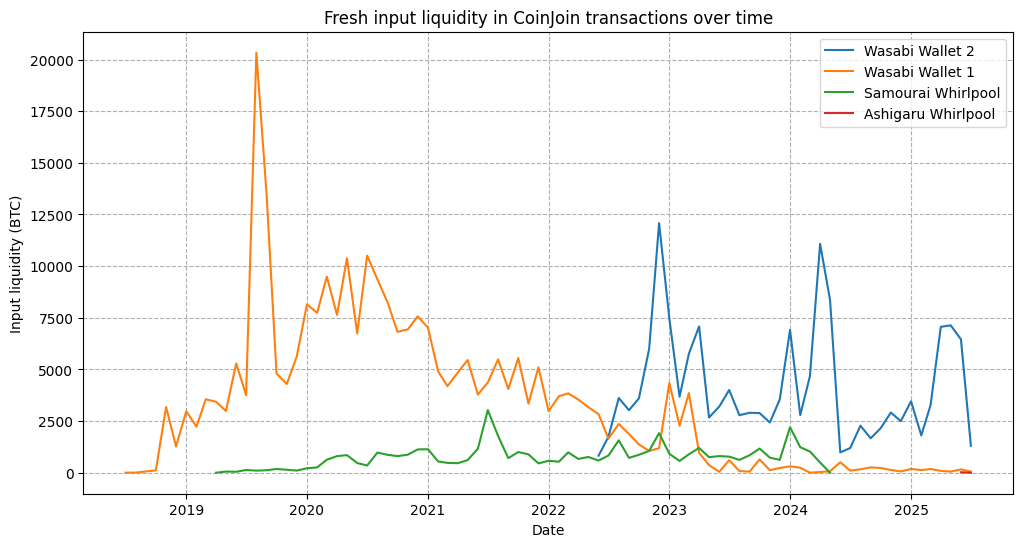

In [20]:
def group_by_week(data):
    weekly_data = defaultdict(int)
    for date, count in data.items():
        nd = datetime.combine(date, datetime.min.time())
        week_start = nd - timedelta(days=nd.weekday())
        weekly_data[week_start] += count

    for k in weekly_data:
        weekly_data[k] /= 7
    return dict(sorted(weekly_data.items()))

print(set(type(x) for x in liq3))

df_ww2 = pd.DataFrame([{"time": time, "count": count} for time, count in liq1.items()])
df_ww1 = pd.DataFrame([{"time": time, "count": count} for time, count in liq2.items()])
df_sw = pd.DataFrame([{"time": time, "count": count} for time, count in liq3.items()])
df_as = pd.DataFrame([{"time": time, "count": count} for time, count in liq4.items()])
df_ww2['time'] = pd.to_datetime(df_ww2['time'])
df_ww1['time'] = pd.to_datetime(df_ww1['time'])
df_as['time'] = pd.to_datetime(df_as['time'])
df_sw['time'] = pd.to_datetime(df_sw['time'])



df_ww2['week'] = df_ww2['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week
df_ww1['week'] = df_ww1['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week
df_sw['week'] = df_sw['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week
df_as['week'] = df_as['time'].dt.to_period('M').dt.to_timestamp()  # Get the timestamp for the start of the week

df_ww2 = df_ww2.groupby("week")["count"].sum().reset_index()
df_ww1 = df_ww1.groupby("week")["count"].sum().reset_index()
df_sw = df_sw.groupby("week")["count"].sum().reset_index()
df_as = df_as.groupby("week")["count"].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_ww2["week"], df_ww2["count"], label="Wasabi Wallet 2")
plt.plot(df_ww1["week"], df_ww1["count"], label="Wasabi Wallet 1")
plt.plot(df_sw["week"], df_sw["count"], label="Samourai Whirlpool")
plt.plot(df_as["week"], df_as["count"], label="Ashigaru Whirlpool")
plt.title("Fresh input liquidity in CoinJoin transactions over time")
plt.xlabel("Date")
plt.ylabel("Input liquidity (BTC)")
plt.legend()
plt.grid(True, ls='--')
plt.savefig("/mnt/blocksci/liquidity_2025_2_inputs.png")
plt.show()


## Traverses

In [21]:
%time flows = chain.find_traverses_between_coinjoins(0, len(chain))

CPU times: user 3h 6min 2s, sys: 3min 40s, total: 3h 9min 42s
Wall time: 3min 51s


In [22]:
def cmp(cjt1, cjt2):
    return int(cjt1) < int(cjt2)

blocksci.CoinJoinType.__lt__ = cmp

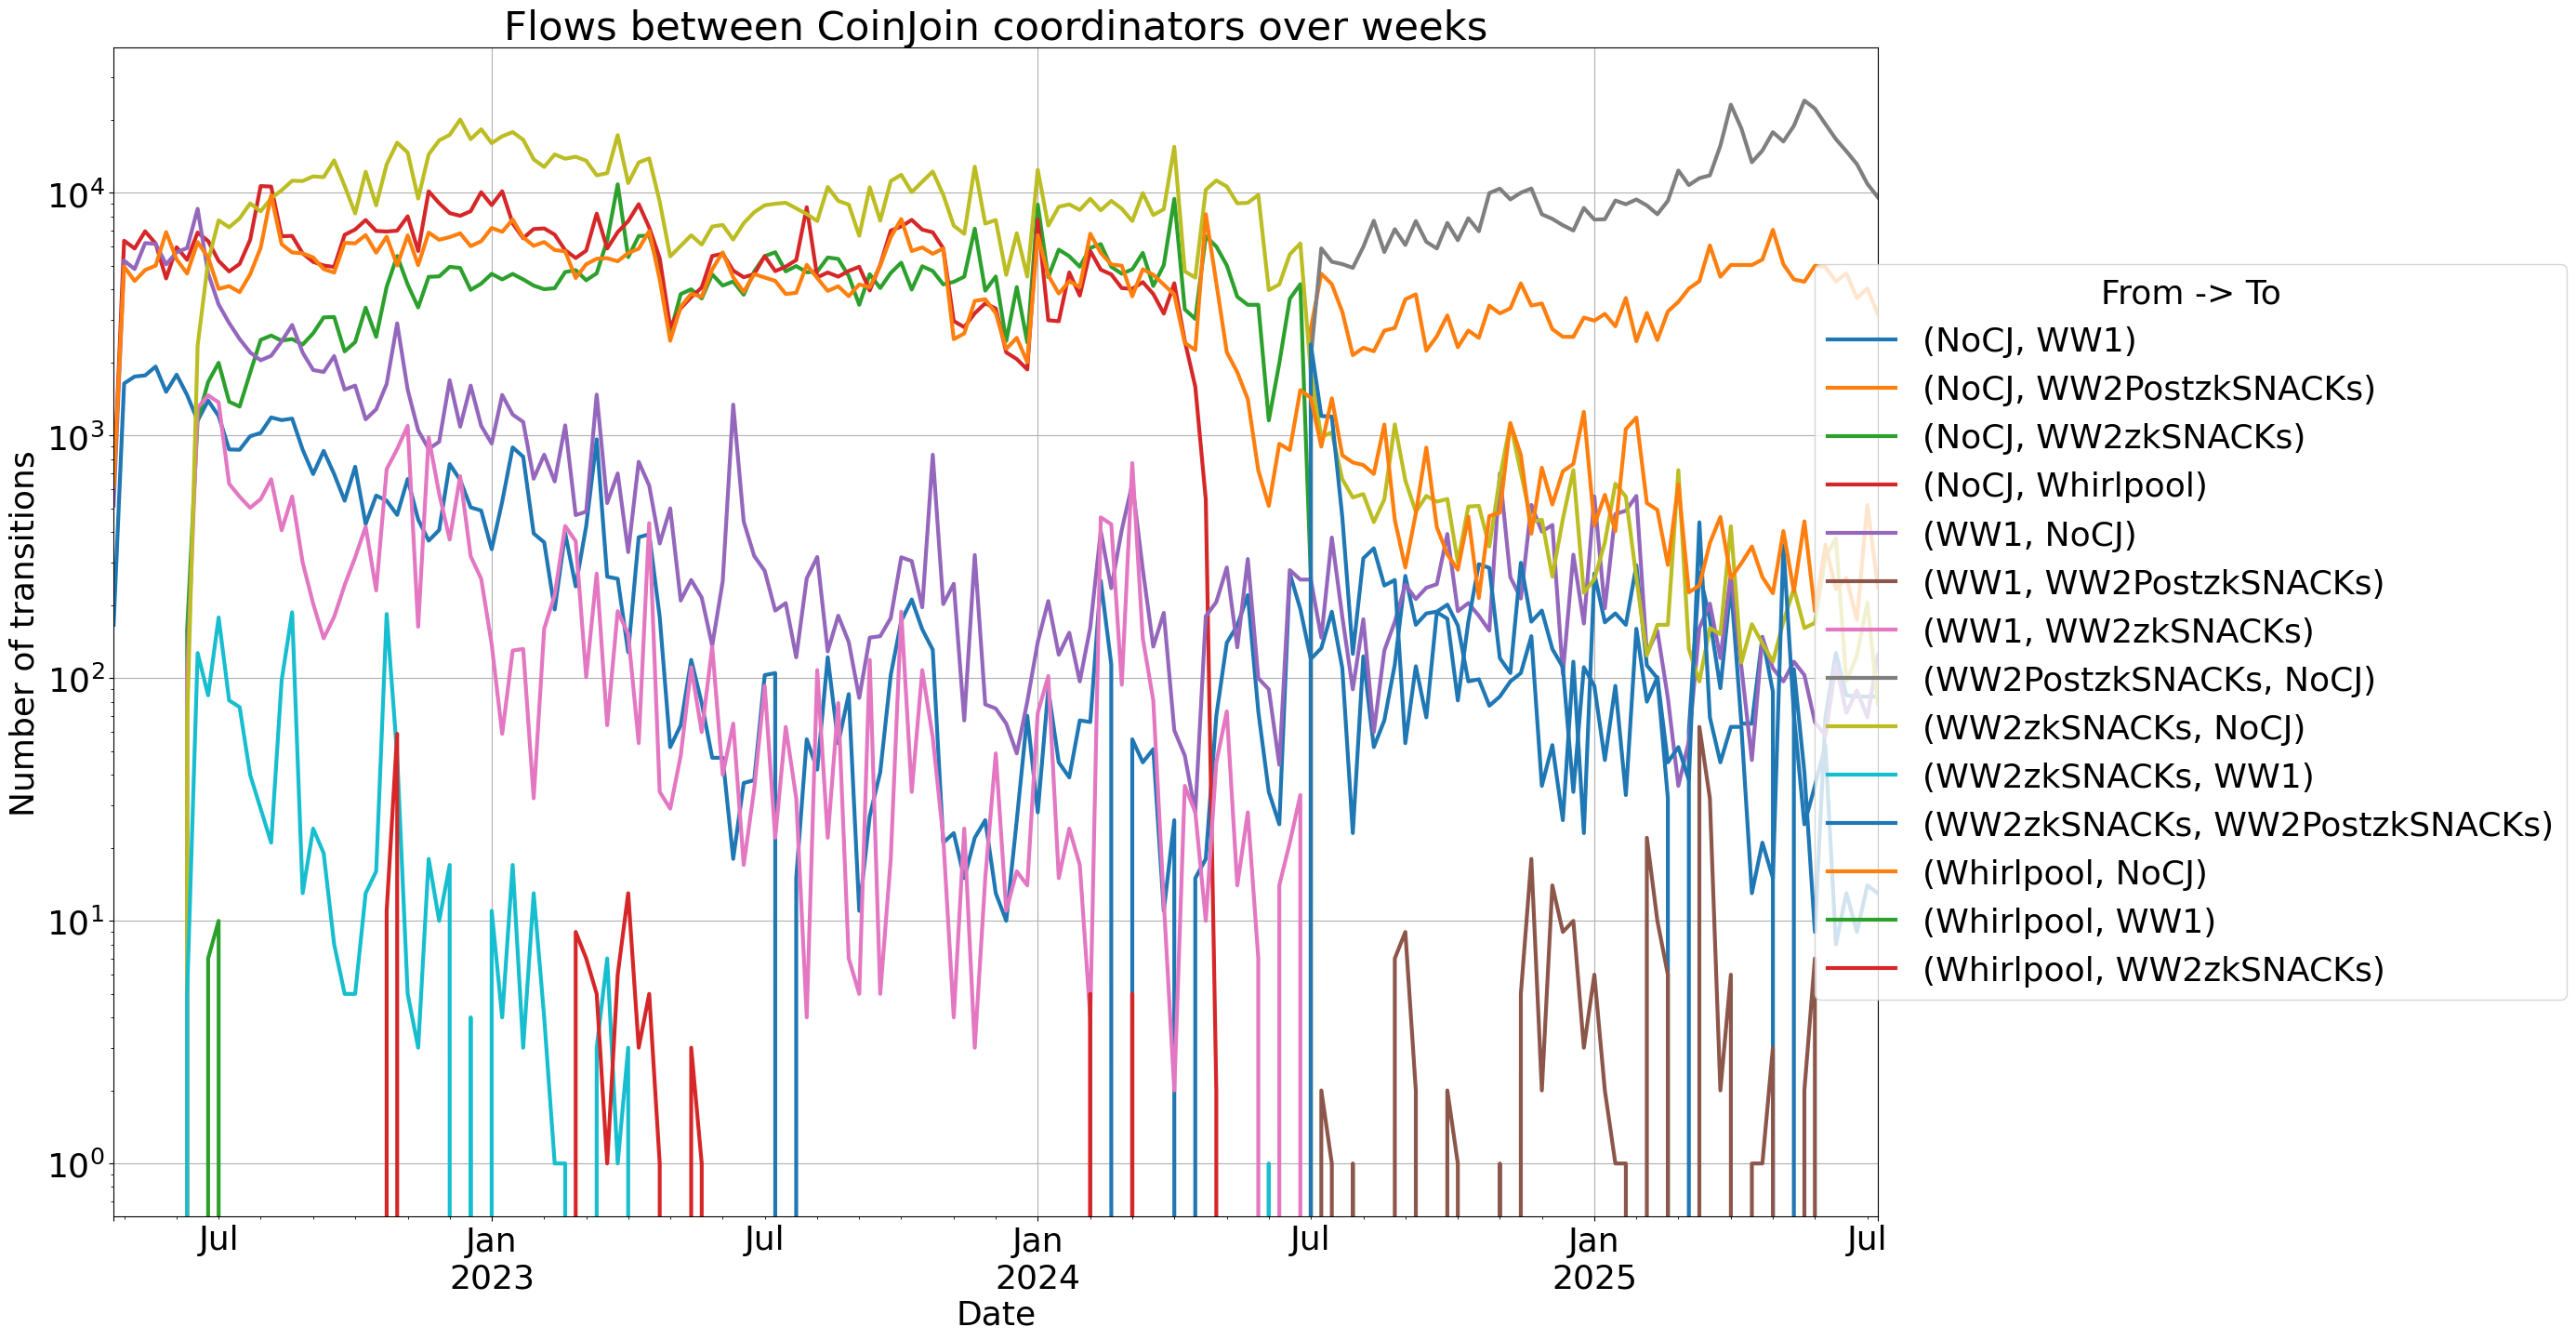

In [23]:
import datetime

# flatten and convert to enums
records = []
for dt, from_map in flows.items():
    for from_cj, to_map in from_map.items():
        for to_cj, count in to_map.items():
            time = chain[dt].time
            # non-relevant values before this date
            if time < datetime.datetime(2022, 5, 1):
                continue
            records.append({"datetime": time, "from_cj": str(blocksci.CoinJoinType(from_cj)).split('.')[1], "to_cj": str(blocksci.CoinJoinType(to_cj)).split('.')[1], "count": count})

df = pd.DataFrame(records)
df['datetime'] = pd.to_datetime(df['datetime'])
df['week'] = df['datetime'].dt.to_period('W').apply(lambda x: x.start_time)

unique_weeks = df['week'].unique()
unique_from_cj = df['from_cj'].unique()
unique_to_cj = df['to_cj'].unique()

full_index = pd.MultiIndex.from_product(
    [unique_weeks, unique_from_cj, unique_to_cj],
    names=["week", "from_cj", "to_cj"]
)

df['week'] = df['week'].dt.normalize()
df_full = df.groupby(['week', 'from_cj', 'to_cj'])['count'].sum().reset_index()
df_full = df_full.set_index(["week", "from_cj", "to_cj"]).reindex(full_index, fill_value=0).reset_index()

pivot_df = df_full.pivot_table(
    index="week",
    columns=["from_cj", "to_cj"],
    values="count",
    fill_value=0
)


pivot_df = pivot_df.drop(columns=pivot_df.columns[(pivot_df == 0).all()])
plt.rcParams.update({'font.size': 26})

pivot_df.plot(figsize=(30, 15), logy=True, linewidth=3)
plt.title("Flows between CoinJoin coordinators over weeks")
plt.xlabel("Date")
plt.ylabel("Number of transitions")
plt.legend(title="From -> To", loc="center right", bbox_to_anchor=(1.4, 0.5))
plt.tight_layout()
plt.grid(True)
plt.savefig("/mnt/blocksci/flows-2025-2_input.png")


plt.show()


## Anonymity degradation

### calculation

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial


def plot_anonymity_degradation(original_data, after_day_data, after_week_data, after_month_data, after_year, after_all, tag, subtag=""):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
            
    df_original = pd.DataFrame(
        # [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in original_data.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "original_anonymity_score"],
    ) if "ignored" not in tag else pd.DataFrame(
        # [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in original_data.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "original_anonymity_score"],
    )

    df_after_day = pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in after_day_data.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_day"],
    ) if "ignored" not in tag else pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in after_day_data.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_day"],
    ) 
    
    df_after_week = pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in after_week_data.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_week"],
    ) if "ignored" not in tag else pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in after_week_data.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_week"],
    )
    
    df_after_month = pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in after_month_data.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_month"],
    ) if "ignored" not in tag else pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in after_month_data.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_month"],
    )

    df_after_year = pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in after_year.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_year"],
    ) if "ignored" not in tag else pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in after_year.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_year"],
    )

    df_after_all = pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_outputs"] or 1) or 1) for transaction, data in after_all.items() if data['total_count'] != 0 and data['not_remixed_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_all"],
    ) if "ignored" not in tag else pd.DataFrame(
        [(transaction.block_time, data["total_count"] / (data["not_remixed_not_ignored_outputs"] or 1) or 1) for transaction, data in after_all.items() if data['total_count'] != 0 and data['not_remixed_not_ignored_outputs'] != 0],
        columns=["block_time", "anonymity_set_after_all"],
    )
    
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_day["block_time"] = pd.to_datetime(df_after_day["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    df_after_year["block_time"] = pd.to_datetime(df_after_year["block_time"])
    df_after_all["block_time"] = pd.to_datetime(df_after_all["block_time"])
    
    df_original["week_start"] = df_original["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_day["week_start"] = df_after_day["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_year["week_start"] = df_after_year["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_all["week_start"] = df_after_all["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_day = df_after_day.groupby("week_start")["anonymity_set_after_day"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    weekly_after_year = df_after_year.groupby("week_start")["anonymity_set_after_year"].mean().reset_index()
    weekly_after_all = df_after_all.groupby("week_start")["anonymity_set_after_all"].mean().reset_index()
    
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_day, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_year, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_all, on="week_start", how="outer")
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(
        weekly_data["week_start"],
        weekly_data["original_anonymity_score"],
        label="Initial computed anonymity value",
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_day"],
        label="Computed anonymity value after 1 day",
        linestyle='dotted'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_week"],
        label="Computed anonymity value after 7 days",
        linestyle='dashed',
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_month"],
        label="Computed anonymity value after 31 days",
        linewidth=1,
        linestyle='dashdot'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_year"],
        label="Computed anonymity value after 365 days",
        linestyle='dotted'
    )

    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_all"],
        label="Computed anonymity value with no time limit",
        linestyle='dashed'
    )
    
    plt.xlabel("Week")
    plt.ylabel("Percentage of unconsolidated outputs")
    plt.title(f"Percentage of unconsolidated outputs for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.ylim(ymin=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_no_remixes_{tag}{'_' + subtag if subtag else ''}_20_input_correct.png")
    plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log2, factorial

def compute_and_plot_differences(original_data, after_day_data, after_week_data, after_month_data, after_year_data, tag, subtag=""):
    def make_df(data, col_name):
        df = pd.DataFrame(
            # [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            [(tx.block_time, data["total_count"] / tx.output_count]) for tx, data in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("M").apply(lambda r: r.start_time)
        return df

    df_original = make_df(original_data, "original_value")
    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_week = make_df(after_week_data, "after_week_value")
    df_after_month = make_df(after_month_data, "after_month_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    df_original = df_original.groupby("week_start")["original_value"].mean().reset_index()
    df_after_day = df_after_day.groupby("week_start")["after_day_value"].mean().reset_index()
    df_after_week = df_after_week.groupby("week_start")["after_week_value"].mean().reset_index()
    df_after_month = df_after_month.groupby("week_start")["after_month_value"].mean().reset_index()
    df_after_year = df_after_year.groupby("week_start")["after_year_value"].mean().reset_index()

    merged = df_original.merge(df_after_day, on="week_start", how="outer")
    merged = merged.merge(df_after_week, on="week_start", how="outer")
    merged = merged.merge(df_after_month, on="week_start", how="outer")
    merged = merged.merge(df_after_year, on="week_start", how="outer")

    merged["diff_0_1d"] = abs(merged["after_day_value"] - merged["original_value"])
    merged["diff_1d_7d"] = abs(merged["after_week_value"] - merged["after_day_value"])
    merged["diff_7d_31d"] = abs(merged["after_month_value"] - merged["after_week_value"])
    merged["diff_31d_365d"] = abs(merged["after_year_value"] - merged["after_month_value"])

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16,6))
    plt.plot(merged["week_start"], merged["diff_0_1d"], label="Difference (0–1d)")
    plt.plot(merged["week_start"], merged["diff_1d_7d"], label="Difference (1d–7d)", ls='--')
    plt.plot(merged["week_start"], merged["diff_7d_31d"], label="Difference (7d–31d)", ls=':')
    plt.plot(merged["week_start"], merged["diff_31d_365d"], label="Difference (31d–365d)", ls='-.')

    plt.xlabel("Month")
    plt.ylabel("Difference in anonymity values")
    plt.title(f"Differences (0–1d, 1d–7d, 7d–31d, 31d-365d) for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_differences_{tag}{'_' + subtag if subtag else ''}_all.png")
    plt.show()
    
    print("original mean", merged["original_value"].mean())
    print("after day", merged["after_day_value"].mean())
    print("after week", merged["after_week_value"].mean())
    print("after month", merged["after_month_value"].mean())
    print("after year", merged["after_year_value"].mean())


def compute_and_plot_quartiles(after_day_data, after_year_data, tag, subtag=""):
    def make_df(data, col_name):
        df = pd.DataFrame(
            # [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            [(tx.block_time, val / tx.output_count) for tx, (_, val) in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
        return df

    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    merged = pd.merge(df_after_day, df_after_year, on=["block_time","week_start"], how="outer")

    weekly = merged.groupby("week_start").agg({
        "after_day_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        "after_year_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
    }).reset_index()

    weekly.columns = [
        "week_start",
        "after_day_mean", "after_day_q1", "after_day_median", "after_day_q3",
        "after_year_mean", "after_year_q1", "after_year_median", "after_year_q3"
    ]
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(weekly["week_start"], weekly["after_day_mean"], label="After 1 day (mean)", color='blue')
    plt.fill_between(weekly["week_start"], weekly["after_day_q1"], weekly["after_day_q3"], color='blue', alpha=0.2, label="1 day (Q1–Q3)")

    plt.plot(weekly["week_start"], weekly["after_year_mean"], label="After 1 year (mean)", color='red')
    plt.fill_between(weekly["week_start"], weekly["after_year_q1"], weekly["after_year_q3"], color='red', alpha=0.2, label="1 year (Q1–Q3)")
    
    plt.xlabel("Week")
    plt.ylabel("Computed anonymity value")
    plt.title(f"After 1 day and 1 year anonymity values with quartiles for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_quartiles_{tag}{'_' + subtag if subtag else ''}_new.png")
    plt.show()


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3440392561.py, line 9)

### results

In [3]:
%time ww1_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1")
%time ww1_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1")
%time ww1_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1")
%time ww1_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1")
%time ww1_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1")
%time ww1_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1")

%time ww2_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2")
%time ww2_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2")
%time ww2_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2")
%time ww2_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2")
%time ww2_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2")
%time ww2_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2")


%time sw_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool")
%time sw_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool")
%time sw_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool")
%time sw_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool")
%time sw_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool")
%time sw_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool")

%time sw_original_data_50m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "50m")
%time sw_after_day_data_50m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "50m")
%time sw_after_week_data_50m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "50m")
%time sw_after_month_data_50m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "50m")
%time sw_after_year_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "50m")
%time sw_after_full_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "50m")

%time sw_original_data_5m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "5m")
%time sw_after_day_data_5m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "5m")
%time sw_after_week_data_5m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "5m")
%time sw_after_month_data_5m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "5m")
%time sw_after_year_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "5m")
%time sw_after_full_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "5m")


%time sw_original_data_1m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "1m")
%time sw_after_day_data_1m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "1m")
%time sw_after_week_data_1m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "1m")
%time sw_after_month_data_1m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "1m")
%time sw_after_year_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "1m")
%time sw_after_full_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "1m")

%time sw_original_data_100k = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "100k")
%time sw_after_day_data_100k = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "100k")
%time sw_after_week_data_100k = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "100k")
%time sw_after_month_data_100k = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "100k")
%time sw_after_year_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "100k")
%time sw_after_full_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "100k")


CPU times: user 9min 1s, sys: 42.4 s, total: 9min 43s
Wall time: 10.3 s
CPU times: user 56min 33s, sys: 7.97 s, total: 56min 41s
Wall time: 31.5 s
CPU times: user 1h 12s, sys: 6.47 s, total: 1h 18s
Wall time: 30.2 s
CPU times: user 59min 13s, sys: 8.09 s, total: 59min 21s
Wall time: 31 s
CPU times: user 56min 32s, sys: 8.57 s, total: 56min 40s
Wall time: 31.6 s
CPU times: user 57min 12s, sys: 8.58 s, total: 57min 21s
Wall time: 32.6 s
CPU times: user 9min 11s, sys: 1.7 s, total: 9min 13s
Wall time: 11.9 s
CPU times: user 1h 1min, sys: 8.6 s, total: 1h 1min 9s
Wall time: 32.6 s
CPU times: user 1h 2s, sys: 6.07 s, total: 1h 8s
Wall time: 31.1 s
CPU times: user 59min 2s, sys: 7.54 s, total: 59min 10s
Wall time: 33.6 s
CPU times: user 1h 6s, sys: 2.83 s, total: 1h 8s
Wall time: 34.1 s
CPU times: user 54min 37s, sys: 6.76 s, total: 54min 44s
Wall time: 39.6 s
CPU times: user 11min 3s, sys: 2.26 s, total: 11min 6s
Wall time: 16 s
CPU times: user 1h 1min 37s, sys: 8.02 s, total: 1h 1min 45s
W

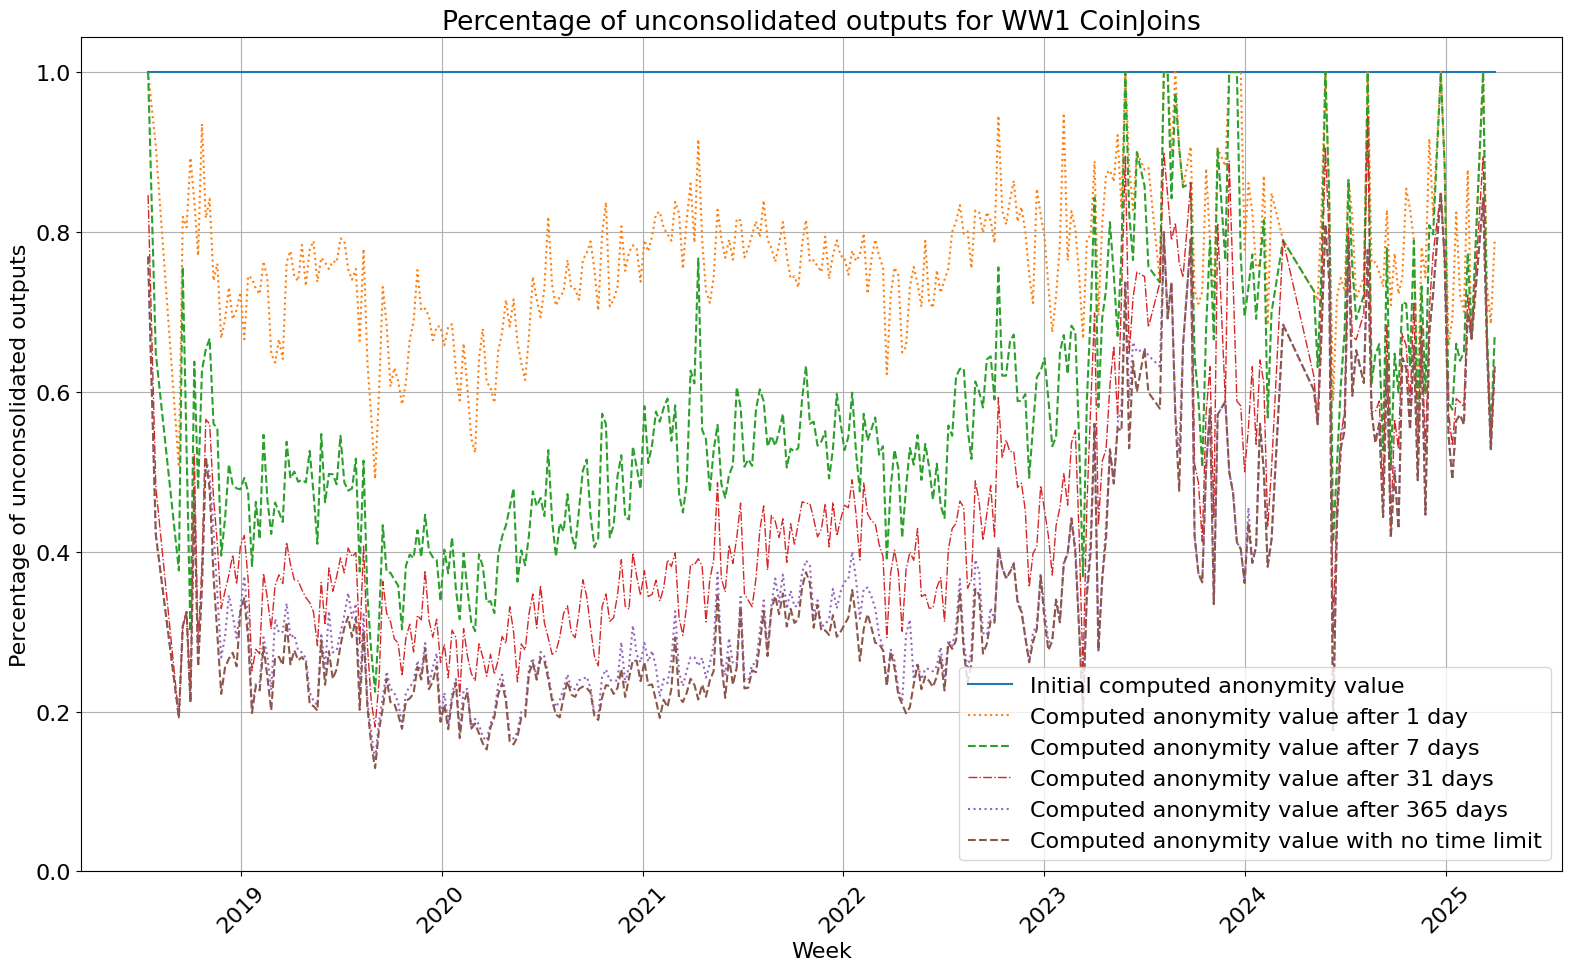

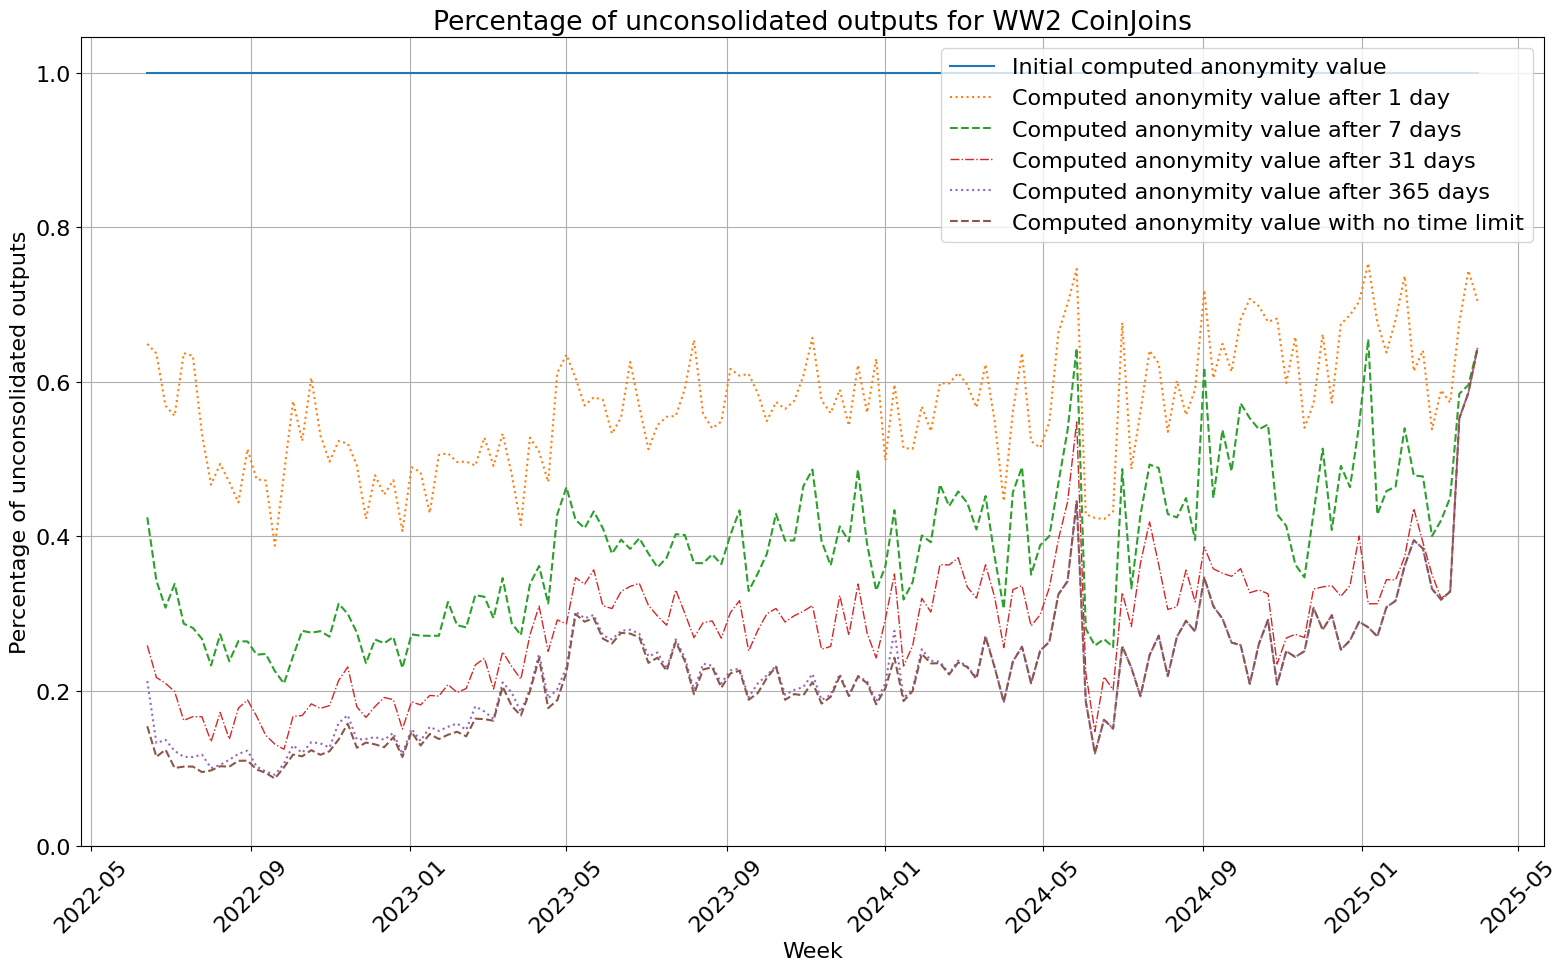

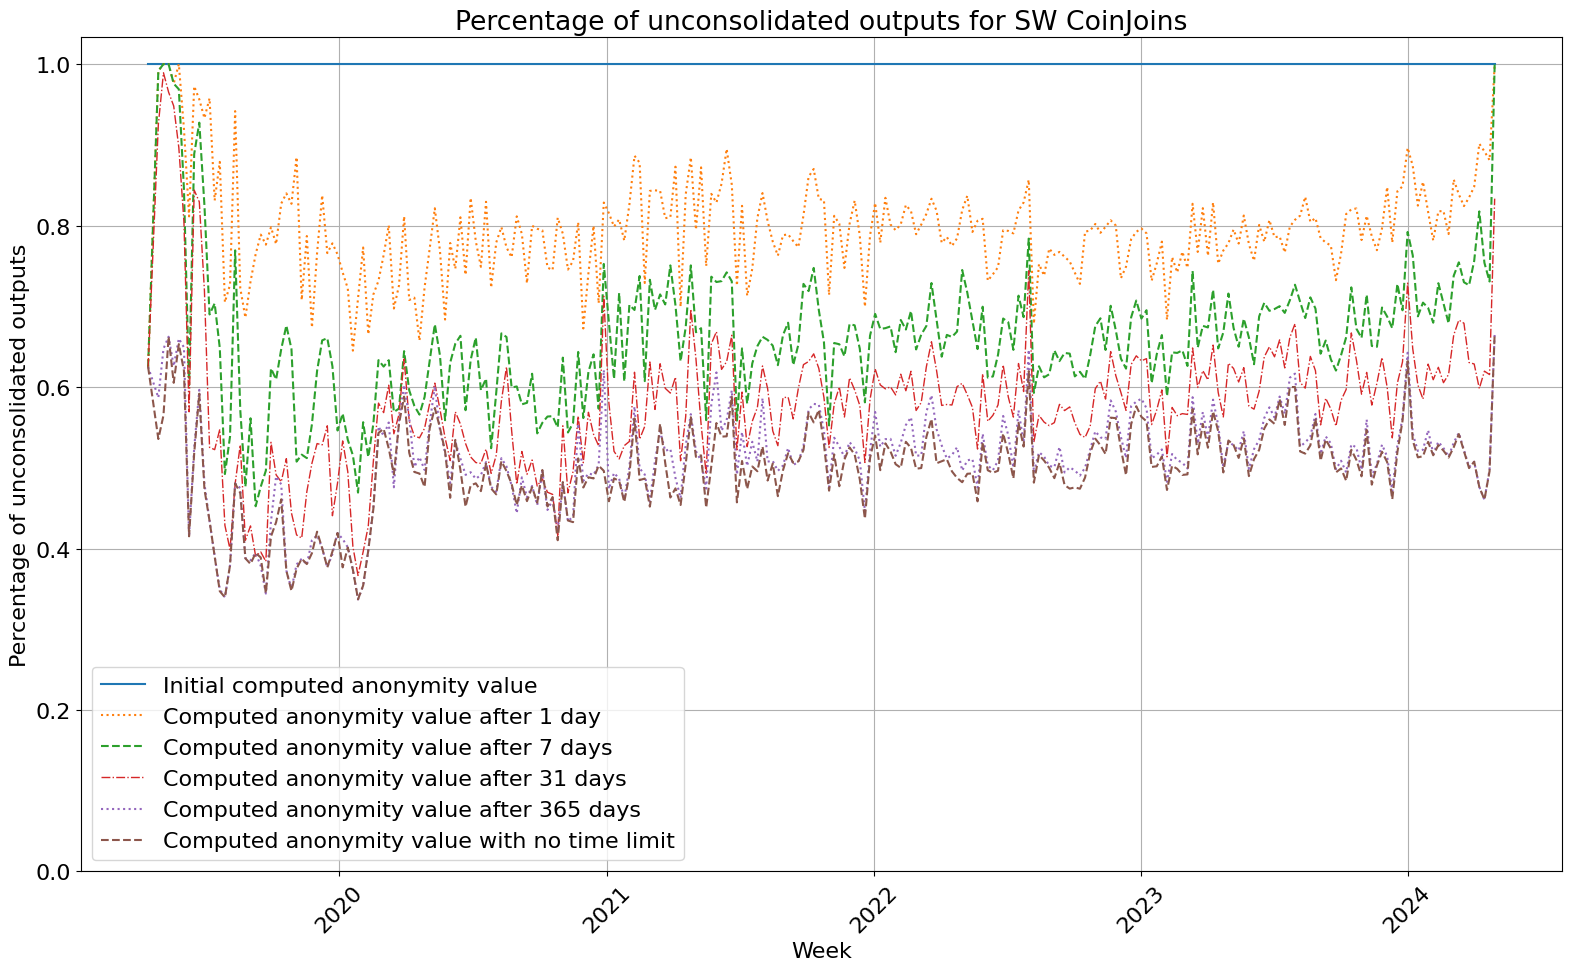

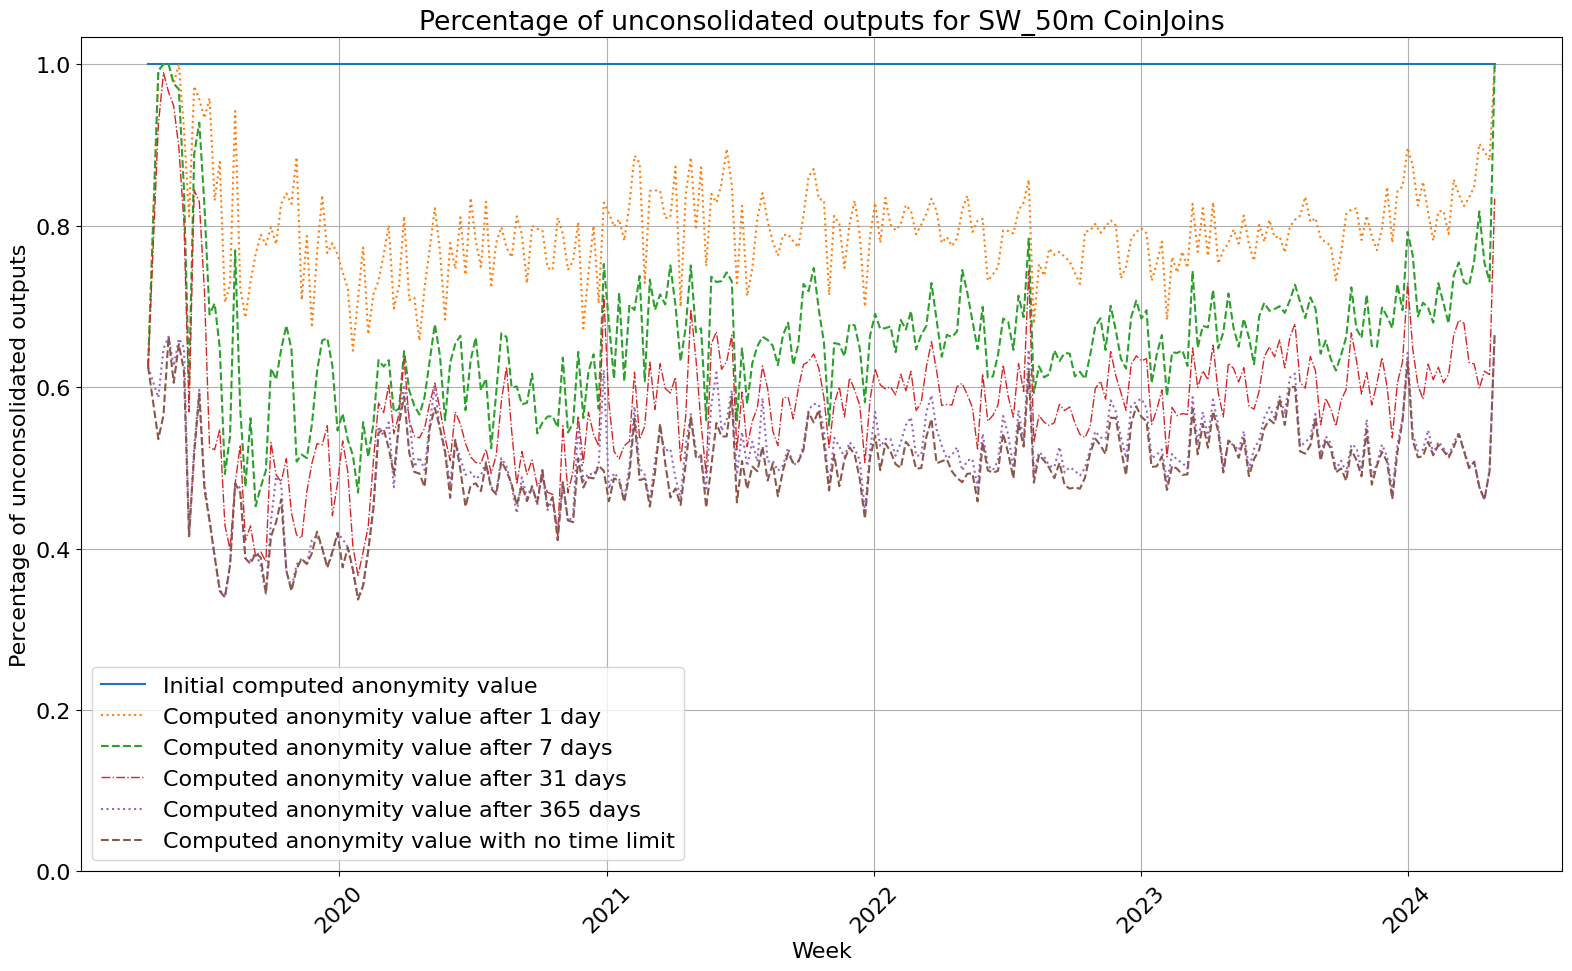

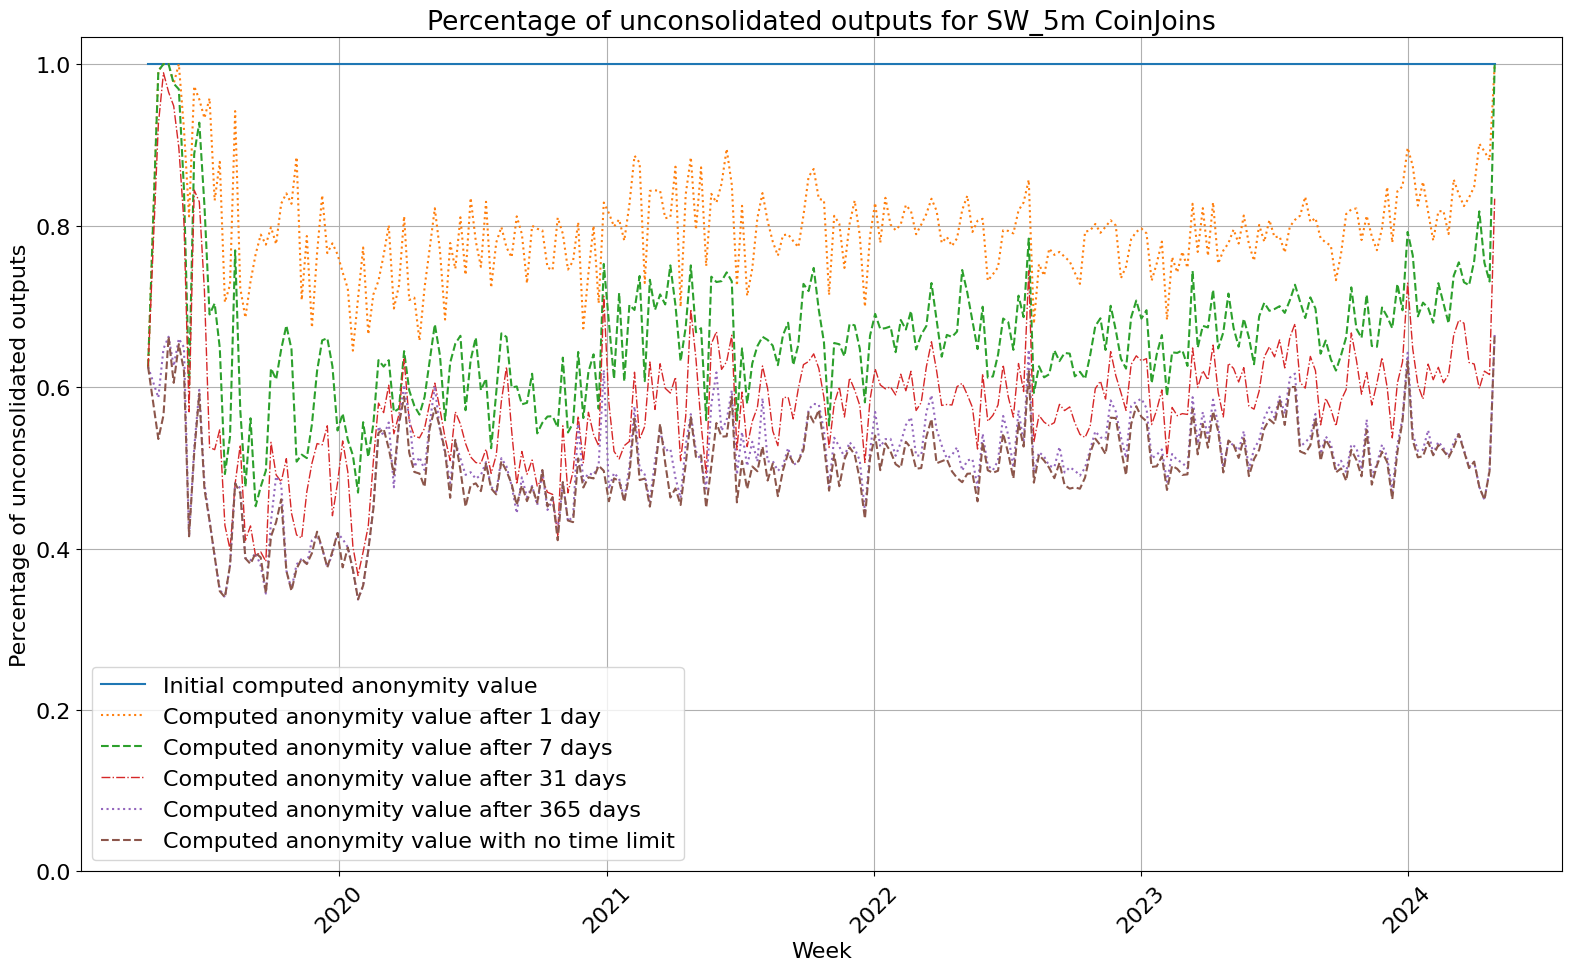

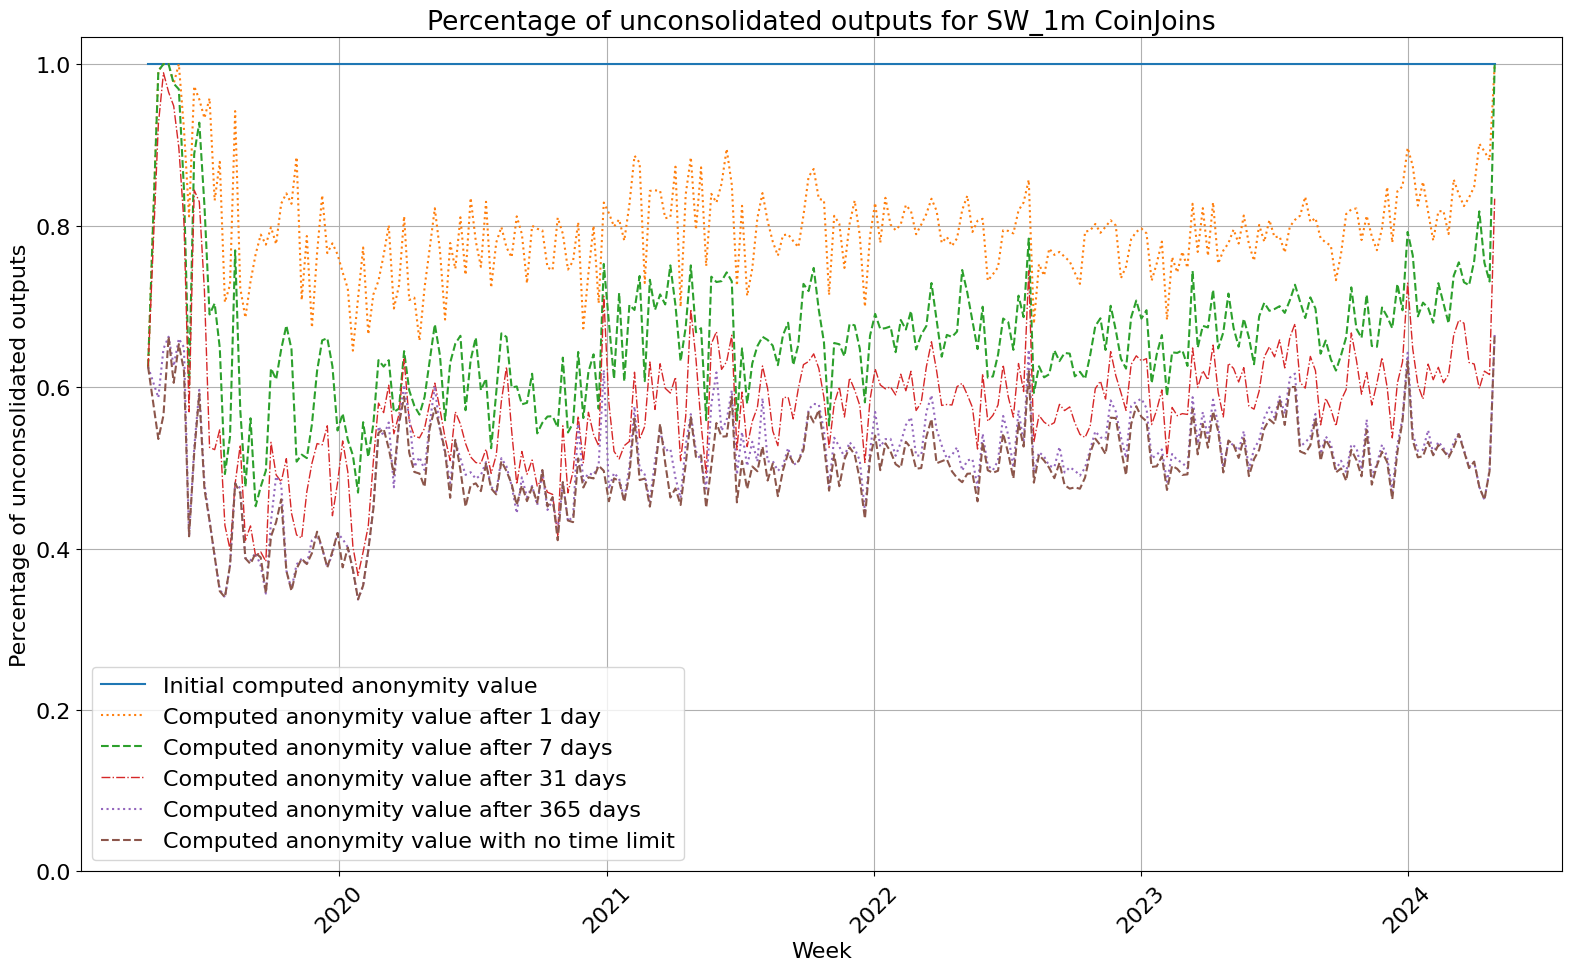

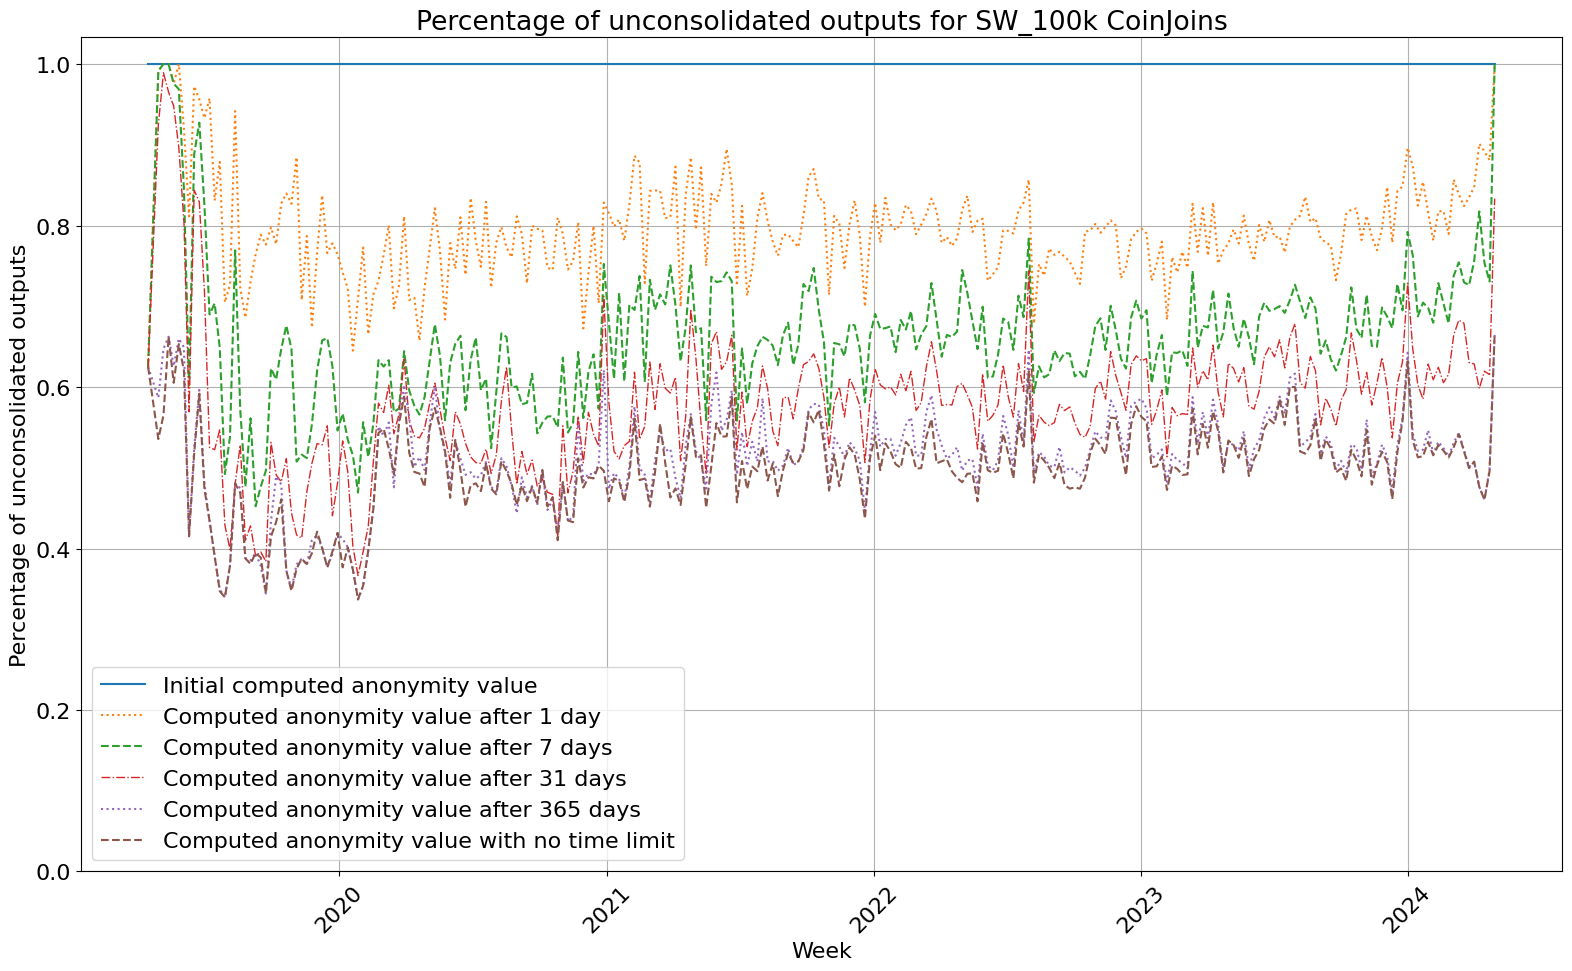

In [4]:
plot_anonymity_degradation(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, ww1_after_full_data, "ww1_multiple_txes")
# compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
# compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")

plot_anonymity_degradation(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, ww2_after_full_data, "ww2_multiple_txes")
# compute_and_plot_differences(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, "ww2_multiple_txes")
# compute_and_plot_quartiles(ww2_after_day_data, ww2_after_year_data, "ww2_cjs")

plot_anonymity_degradation(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, sw_after_full_data, "sw_multiple_txes")
# compute_and_plot_differences(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, "sw_multiple_txes")
# compute_and_plot_quartiles(sw_after_day_data, sw_after_year_data, "sw_cjs")

plot_anonymity_degradation(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, sw_after_full_data_50m, "sw_multiple_txes", "50m")
# compute_and_plot_differences(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, "sw_multiple_txes", "50m")
# compute_and_plot_quartiles(sw_after_day_data_50m, sw_after_year_data_50m, "sw_cjs", "50m")

plot_anonymity_degradation(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, sw_after_full_data_5m, "sw_multiple_txes", "5m")
# compute_and_plot_differences(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, "sw_multiple_txes", "5m")
# compute_and_plot_quartiles(sw_after_day_data_5m, sw_after_year_data_5m, "sw_cjs", "5m")


plot_anonymity_degradation(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, sw_after_full_data_1m, "sw_multiple_txes", "1m")
# compute_and_plot_differences(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, "sw_multiple_txes", "1m")
# compute_and_plot_quartiles(sw_after_day_data_1m, sw_after_year_data_1m, "sw_cjs", "1m")


plot_anonymity_degradation(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, sw_after_full_data_100k, "sw_multiple_txes", "100k")
# compute_and_plot_differences(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, "sw_multiple_txes", "100k")
# compute_and_plot_quartiles(sw_after_day_data_100k, sw_after_year_data_100k, "sw_cjs", "100k")

In [5]:
%time ww1_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ignoreNonStandardDenominations=True)

%time ww2_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2", ignoreNonStandardDenominations=True)
%time ww2_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2", ignoreNonStandardDenominations=True)

CPU times: user 9min 8s, sys: 876 ms, total: 9min 9s
Wall time: 9.82 s
CPU times: user 55min 17s, sys: 3.65 s, total: 55min 20s
Wall time: 32.6 s
CPU times: user 56min 57s, sys: 5.41 s, total: 57min 3s
Wall time: 31.2 s
CPU times: user 58min 58s, sys: 2.96 s, total: 59min 1s
Wall time: 33.7 s
CPU times: user 55min 51s, sys: 2.16 s, total: 55min 53s
Wall time: 33.4 s
CPU times: user 54min 55s, sys: 4.49 s, total: 54min 59s
Wall time: 36 s
CPU times: user 8min 20s, sys: 1.05 s, total: 8min 21s
Wall time: 13.5 s
CPU times: user 58min 14s, sys: 3.34 s, total: 58min 17s
Wall time: 35.3 s
CPU times: user 1h 4min 13s, sys: 2.68 s, total: 1h 4min 16s
Wall time: 34.2 s
CPU times: user 1h 1min 14s, sys: 7.39 s, total: 1h 1min 22s
Wall time: 34.7 s
CPU times: user 1h 34s, sys: 3.41 s, total: 1h 38s
Wall time: 32.3 s
CPU times: user 1h 2min 33s, sys: 3.18 s, total: 1h 2min 36s
Wall time: 33.5 s


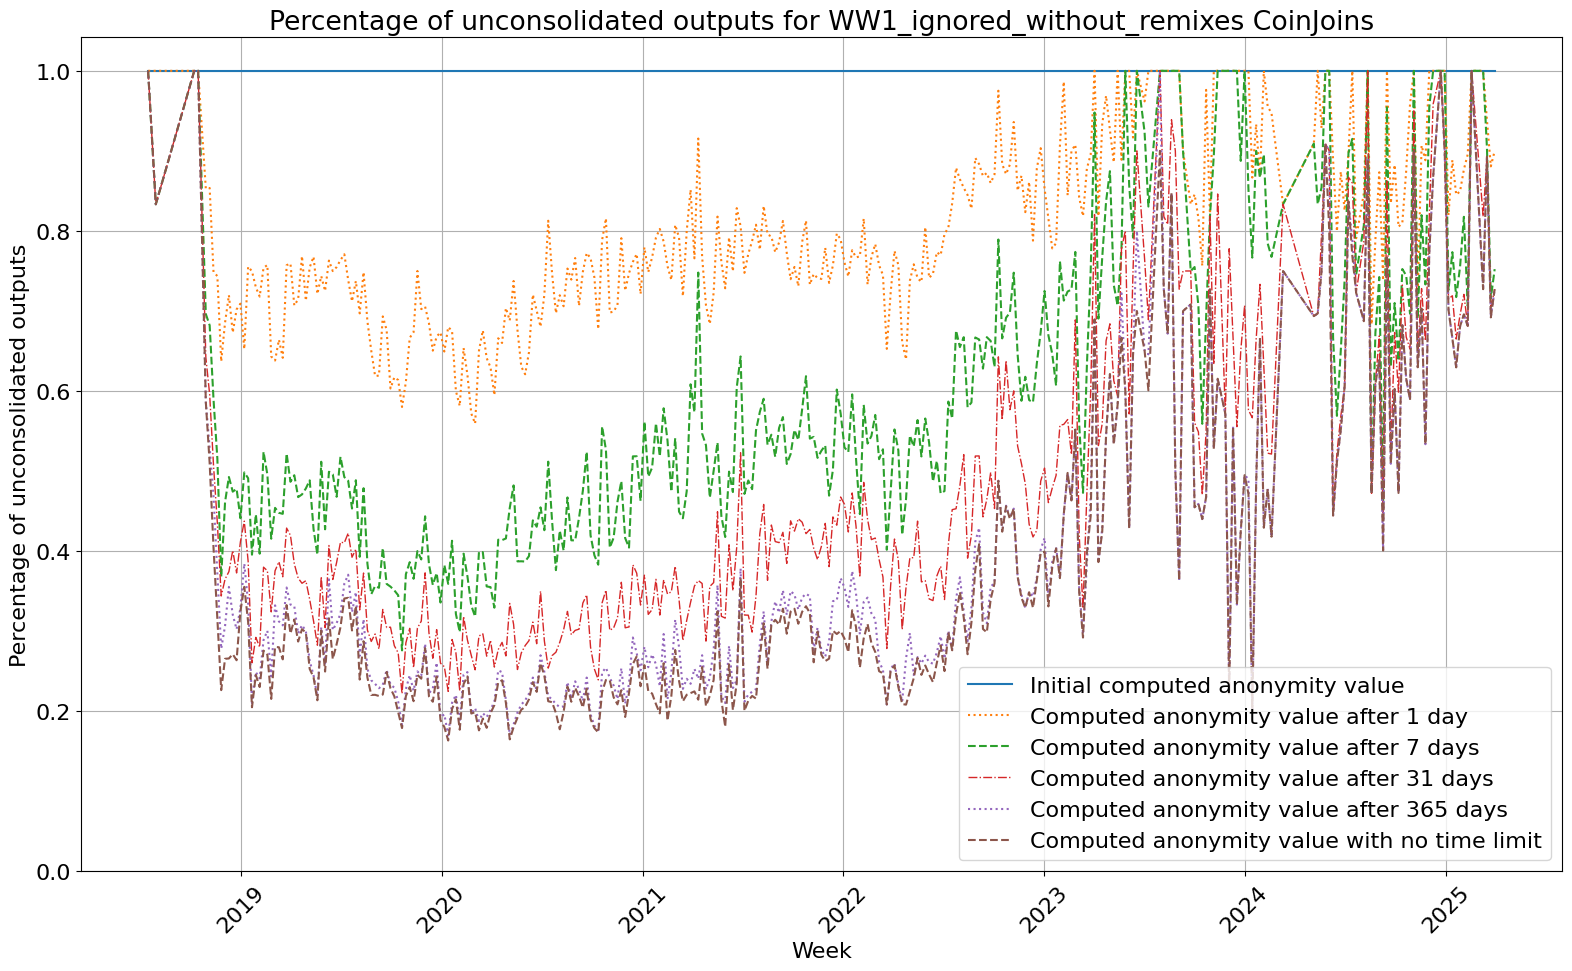

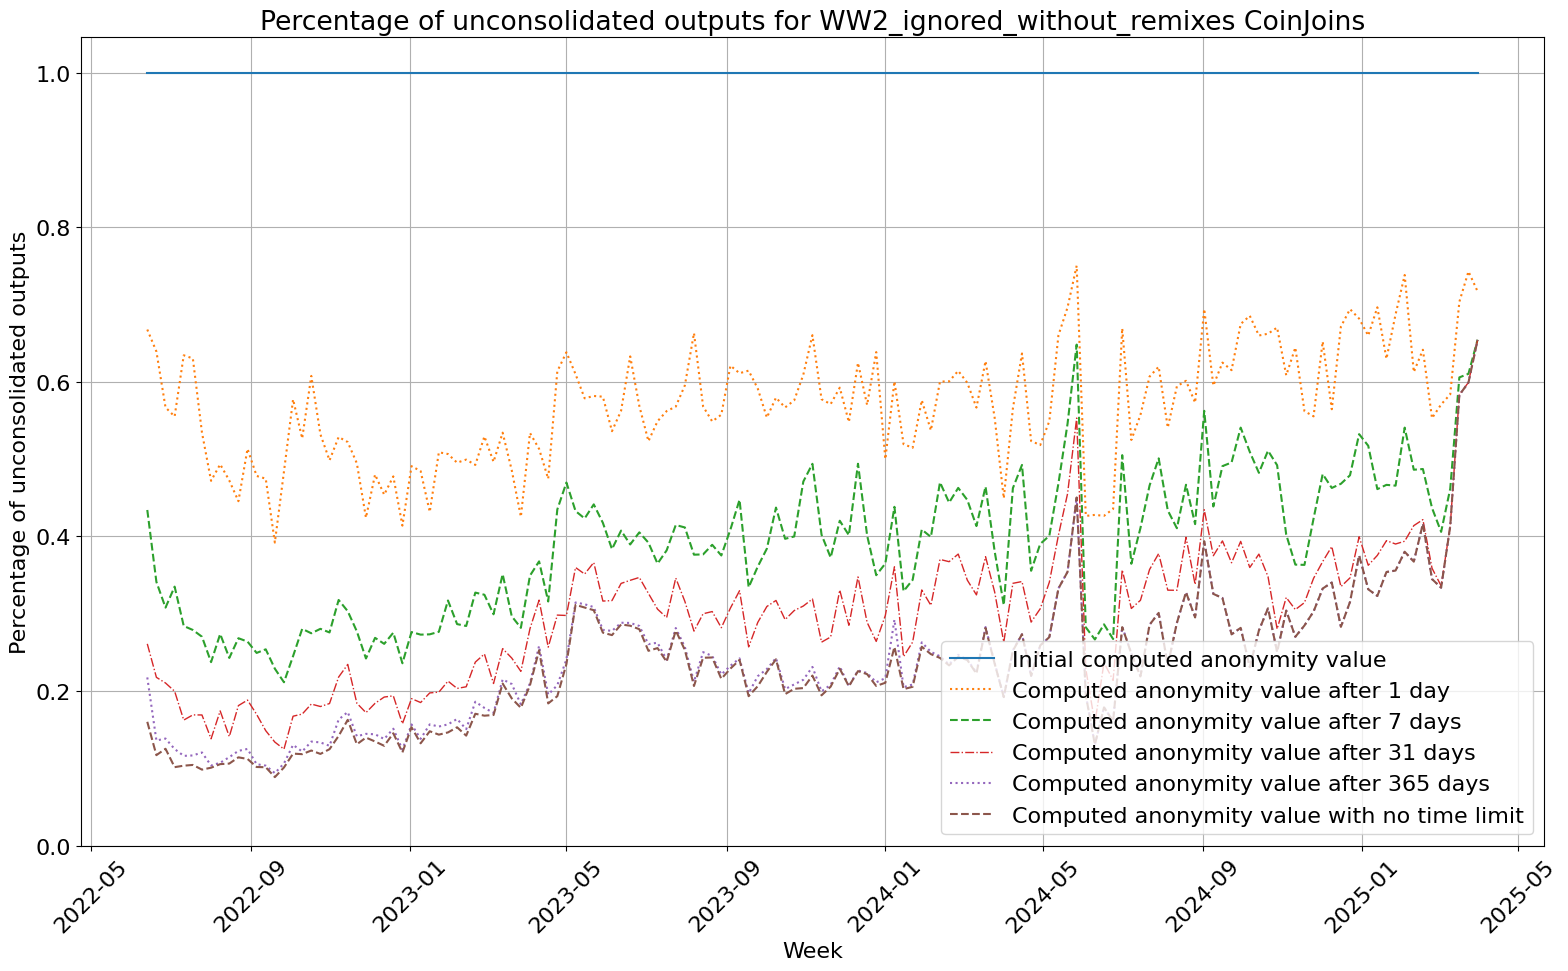

In [9]:
plot_anonymity_degradation(ww1_ign_original_data, ww1_ign_after_day_data, ww1_ign_after_week_data, ww1_ign_after_month_data, ww1_ign_after_year_data, ww1_ign_after_full_data, "ww1_multiple_txes_ignored", "ignored_without_remixes")

plot_anonymity_degradation(ww2_ign_original_data, ww2_ign_after_day_data, ww2_ign_after_week_data, ww2_ign_after_month_data, ww2_ign_after_year_data, ww2_ign_after_full_data, "ww2_multiple_txes_ignored", "ignored_without_remixes")
# compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
# compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")


# Bybit addresses crusade

In [13]:
import json
with open("/mnt/anal/wasabi2_kruw_events_22-27.json", "r") as f:
    kruw_data = json.load(f)

# kruw_data["f3c6822ddf648f7fe607c6b108d22473404a1cdb1e26b647dafef5d7e70e8075"] = None
# kruw_data = {"0e173a4203b7d6a42b5a490c852c29431eca5d85ff6ea60462571892eefe5aac": None}

kruw_txes = set(chain.tx_with_hash(h) for h in kruw_data)
print(len(kruw_txes))

162


In [14]:
import requests

bybit_data = requests.get("https://hackscan.hackbounty.io/public/hack-address.json").json()
bybit_btc_addresses = set()
for a in bybit_data['0221']['btc']:
    try:
        address = chain.address_from_string(a)
        if address is None:
            continue
        bybit_btc_addresses.add(address)
    except Exception as e:
        print(e)
        print(a)



Tried to construct invalid address
0x092c751FBC32d693535B8c0713979A8ef150D2e9
Tried to construct invalid address
0x79374d65B8370E3D4da9ce665c64a20E77BAC761
Tried to construct invalid address
0xb44da43caa4285265f0e8396bed1a65f1523713d


In [4]:

a = chain.address_from_string("bc1q533d9nuatdz8j926x9ezmsugv2hu82d3hypzda")
print(a in bybit_btc_addresses)

True


In [15]:
for address in bybit_btc_addresses:
    if not isinstance(address, blocksci.Address):
        print(address)

%time distances = chain.find_kruw_paths_to_bybit(start=get_block_height_for_date("2025-03-10"), stop=len(chain), kruw_tx_ids=kruw_txes, bybit_addresses=bybit_btc_addresses, max_hops=9)

KRUW txes: 162
Bybit addresses: 10478
Max hops: 9
CPU times: user 24min 32s, sys: 18min 59s, total: 43min 32s
Wall time: 11min 55s


In [16]:
print(len(distances))
# {
#     "hits": {
#         "adresa_do_které_se_dá_dostat": [
#             {
#                 "txid": "b3fd422d2f3638183a7aececc205b8fcb02da629de4a956aa218199dbc741e96", //coinjoin
#                 "input_index": "78",
#                 "value": 1462644,
#                 "broadcast_time": "2025-02-25 14:32:46.000",
#                 "hops": 5,
#                 "parent_address": ...,
#                 "path": ["parrent_address",...,"this_address"]
#             }
#         ],
# }

result = {}
tx: blocksci.Tx
address: blocksci.Address
max_value = 0
import json
for tx in distances:
    imm = distances[tx]
    for address in imm:
        paths = distances[tx][address]
        for path in paths:
            if str(address) not in result:
                result[str(address)] = []
            last_tx = chain.tx_with_hash(path[0])
            result[str(address)].append({
                "txid_coinjoin": str(tx.hash),
                "txid": str(last_tx.hash),
                "value": last_tx.output_value,
                "broadcast_time_coinjoin": tx.block_time.isoformat(),
                "broadcast_time": last_tx.block_time.isoformat(),
                "path": path,
            })
            if last_tx.output_value > max_value:
                max_value = last_tx.output_value

with open("/mnt/blocksci/results/bybit_kruw_20_input.json", "w") as f:
    f.write(json.dumps(result, indent=4))

print(max_value / 100000000)

102
36.08702902


In [7]:
tx = chain.tx_with_hash("97df6540fba1af22bc69a4604ae22351ea71a9d19b803e5fce4b6cca37450cde")
# print(tx.is_ww2_cj_debug)
path = ["25e6a61f86bb49ad2f8b65f80e15fccd99a24448eca3f4ac35b84e7828c2598e", "f112482ddb0aabd8bf5e44cd33ff9588f6d741b7e1305ec0526ee069b7da561d", "e66d9ac49856f176801ebfe5ec775571aa640a7713f187de17a5d2dc3d9d9bff" ]
path = list(map(lambda t: chain.tx_with_hash(t), path))
for tx in path:
    print(tx.hash)
    print(tx.is_ww2_cj_debug)

25e6a61f86bb49ad2f8b65f80e15fccd99a24448eca3f4ac35b84e7828c2598e
False
f112482ddb0aabd8bf5e44cd33ff9588f6d741b7e1305ec0526ee069b7da561d
False
e66d9ac49856f176801ebfe5ec775571aa640a7713f187de17a5d2dc3d9d9bff
True
Output count: 195, 197.6
Output count: 212, 213.6
Output count: 242, 212
